This notebook gives some examples of the Widely Applicable Bayesian Information Criterion (WBIC) and its use with STAN.


The three cases considered are:
<ol>
<li>Linear Model vs Generalized Linear Model</li>
<li>Linear model feature selection </li>
<li>AR order determination </li>
</ol>

In [1]:
# this section imports stuff 
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import arviz as az
from platform import python_version
import matplotlib.pyplot as plt
from orbit.utils.simulation import make_regression

In [2]:
%matplotlib inline

In [3]:
# check the things!
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pystan: {}'.format(pystan.__version__))
print(python_version())

pandas: 1.3.1
numpy: 1.21.1
pystan: 2.19.1.1
3.7.8


This section gives the WAIC function. For it to work the models must have a log probability of each observation for each sample. 

Note that the penalty term (k) is currently left as an argument to the user. In "Understanding predictive information criteria for Bayesian models” and "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC" k=2 is assumed. As is discussed here k = log(n) mighte be another choice. Note this is not WBIC which is its own thing. 



In [4]:
#WAIC
def WAIC(log_p, k = 2 ):
    P_WAIC2 = np.nansum(log_p.var(axis=0)) # the effective number of paramters 
    lppd = np.nansum(np.log(np.exp(log_p).mean(axis=0))) # the sum of log pointwise predictive density
    WAIC = -2*lppd +k* P_WAIC2 
    return WAIC, lppd, P_WAIC2


def WBIC(log_p): # note that log P must he sampled at temp log(n)
    return -2*np.nanmean(log_p)

## First example:
This example considers the fitting of linear model with both a normal and a  Generalized normal distribution 

In [5]:
# make data 
n = 10000
x0 = np.ones(n)
x1 = np.random.normal(0, 10, n)
x2 = np.random.normal(0, 0.5, n)

X = np.vstack([x0, x1, x2]).transpose()


coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(10000, 3)
(10000,)
[2.6 0.2 0.1]


Four parts to a STAN process. Data, Model, Fitting, and outputs

In [6]:
# data
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [7]:
# make model 1 
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] m;
      real<lower=0,upper=10> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      
      yhat = X * m;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      for (i in 1:n_obs)
        target += watanabe_beta*log_p[i];
    }
    
"""
sm_simple = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ae105309d20e0781eff0ae7263bdd21 NOW.


In [8]:
# make model 2 
model_code = """
    functions{
    real gen_norm_lpdf(real x, real alpha, real beta, real mu){
        return(log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(x-mu)/alpha, beta) );        
        }
    }

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] m;
      real<lower=0> alpha;
      real<lower=0,upper=5> beta;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      yhat = X * m;
      for (i in 1:n_obs)
          log_p[i] = log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(y[i]-yhat[i])/alpha, beta);
    }
    
    model {
      //vector[n_obs] yhat;
      //yhat = X * m;
      alpha ~ uniform(0, 10);
      beta ~ uniform(0, 5);
      
      for (i in 1:n_obs)
          target += watanabe_beta*log_p[i];
    }
    
"""
sm_complex = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d8f24b83a2d491827d4e5301a729307 NOW.


In [9]:
%%time
# fit the models 
fit_simple = sm_simple.sampling(data=data, iter=10000, chains=4, verbose =True)
fit_complex = sm_complex.sampling(data=data, iter=10000, chains=4, verbose =True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
# extract the posteriors
posteriors_simple = fit_simple.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_simple.keys())

posteriors_complex = fit_complex.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_complex.keys())

odict_keys(['m', 'sigma', 'yhat', 'log_p', 'watanabe_beta', 'lp__'])
odict_keys(['m', 'alpha', 'beta', 'yhat', 'log_p', 'watanabe_beta', 'lp__'])


In [11]:
WBIC_s = WBIC(log_p = posteriors_simple['log_p'])
WBIC_c = WBIC(log_p = posteriors_complex['log_p'])

print(WBIC_s)
print(WBIC_c)

2.847699801079601
2.8484211202879623


## Example 2
Feature selection for linear models with WBIC.

In [12]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X9 = np.vstack([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]).transpose()
X = np.vstack([x0, x1, x2]).transpose()
coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


In [13]:
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [14]:
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] m;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      
      yhat = X * m;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      for (i in 1:n_obs)
        target += watanabe_beta*log_p[i];
    }
    
"""
sm_temp = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2 NOW.


In [15]:
%%time
# this cell loops through models with different number of features
WBIC_list = np.zeros((10))

for i in range(1, 10):
    X = X9.copy()
    X = X[:,:i]
    print(X.shape[1])
    data = {
        'n_obs': len(y),
        'n_features': X.shape[1],
        'y': y,
        'X': X,
    }
    
    fit_temp = sm_temp.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_temp = fit_temp.extract(permuted=True)
    WBIC_v = WBIC(log_p = posteriors_temp['log_p'])
    WBIC_list[i-1] = WBIC_v

    
    print("-------------------------------------------------------------------------------")
    print(i)
    print(WBIC_v)
    print("-------------------------------------------------------------------------------")    

1


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2.9063037007630568
-------------------------------------------------------------------------------
2


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2.8721671190442772
-------------------------------------------------------------------------------
3


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2.865806831433381
-------------------------------------------------------------------------------
4


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2.871647645932829
-------------------------------------------------------------------------------
5


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2.878986643195287
-------------------------------------------------------------------------------
6


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2.884619893243235
-------------------------------------------------------------------------------
7


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2.8892100631740107
-------------------------------------------------------------------------------
8


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2.8965192785828835
-------------------------------------------------------------------------------
9


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2.9027013856931365
-------------------------------------------------------------------------------


[2.9063037  2.87216712 2.86580683 2.87164765 2.87898664 2.88461989
 2.88921006 2.89651928 2.90270139 0.        ]


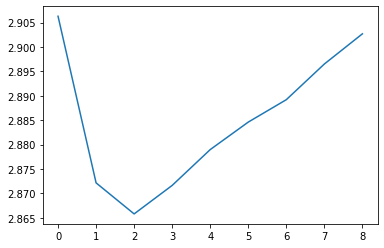

In [16]:
print(WBIC_list)

plt.plot(WBIC_list[0:9])

The min WAIC should be for the 3rd itteration

## Example 3
AR order selections

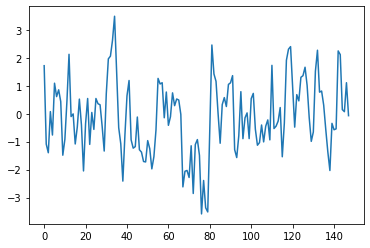

In [17]:
# make the data
n = 1000
eta = np.random.normal(0, 1, n)
rho = [0.85, -0.25]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + eta[i]

#plt.plot(y)
plt.plot(y[2:150])

In [18]:
data = {
    'N': len(y),
    'K': 3,
    'y': y,
}

In [19]:
model_code = """
    data {
      int<lower=0> K;
      int<lower=0> N;
      real y[N];
    }
    parameters {
      real<lower=-1,upper=1> rho[K];
      real sigma;
    }
    
    
    transformed parameters {
        vector[N] yhat;
        vector[N] log_p;
        real watanabe_beta;
        watanabe_beta = 1.0/log(N); // the sampling temp  
      
        for (i in (K+1):N) {
            yhat[i] = 0;
            for (k in 1:K)
              yhat[i] += rho[k] * y[i-k];
            log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
            }
    }
    
    
    model {
      
      for (i in (K+1):N) 
        target += watanabe_beta*log_p[i];
      
    }"""
AR_K = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6 NOW.


In [22]:
%%time
WBIC_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    WBIC_v = WBIC(log_p = posteriors_AR_K['log_p'])
    WBIC_list[k-1] = WBIC_v

    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WBIC_v)
    print("-------------------------------------------------------------------------------")    
    

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2.8371129975406033
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2.811160989901694
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2.818048357305861
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2.818011002681719
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2.826191345078364
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2.8335337543775094
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2.837301286045876
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2.8422264880424373
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2.8516396717136554
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2.8572050065759296
-------------------------------------------------------------------------------
CPU times: user 2.48 s, sys: 3.9 s, total: 6.38 s
Wall time: 1min 14s


[2.83709801 2.81210601 2.81696354 2.81769396 2.82681417 2.83353885
 2.83802627 2.84309132 2.84895906 2.85853395]


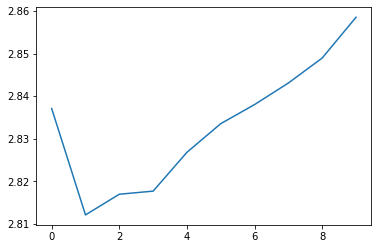

In [21]:
print(WBIC_list)

plt.plot(WBIC_list)

The above should show that the 2nd iteration is best 